In [35]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import joblib
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

In [36]:
df_neurodegenerative = pd.read_csv("../Training_neurodegenerative.csv")

In [37]:
df_hc = pd.read_csv("../Training_healthycontrol.csv")

In [38]:
df_dates_ond =pd.read_csv("../Neurodegenerative_training_date_diagnosis.csv")

In [39]:
protein_cols = df_hc.columns[1:-1].tolist()

In [40]:
covariates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/proteomics/Processed_all_covariates.csv").iloc[:,1:]


In [41]:
covariates_cols = ["plate", "Age", "Sex", "Ethnicity", "BMI", "smoking", "alcohol", "Season", "fasting_time","sample_age","assessment_center","well"]

In [42]:
categorical_cols = ["plate", "well",  "Season",  "assessment_center","Batch"]

In [43]:
covariates[categorical_cols] = covariates[categorical_cols].astype(str)

In [44]:
covariates["Sex"] = covariates["Sex"].replace({1:"Male", 0:"Female" })

In [45]:
df_neuro = pd.merge(covariates, df_neurodegenerative, on=["eid"])
df_hc = pd.merge(covariates, df_hc, on=["eid"])
df_pd = df_hc[df_hc["Diagnosis"] == 1]
df_hc = df_hc[df_hc["Diagnosis"] == 0]
df_neuro = df_neuro[df_neuro["Diagnosis"] == 0]

In [46]:
df_neuro

,eid,plate,Batch,Age,Sex,Ethnicity,BMI,smoking,alcohol,Season,...,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,Diagnosis
1,2793297,890000000003,1,69,Male,White,25.1685,1.0,2.0,Winter/Spring,...,0.0170,-0.5092,NaN,-0.1046,0.90240,0.5428,1.8288,0.1272,-1.0373,0
2,1032727,890000000004,1,63,Female,White,23.1867,0.0,1.0,Summer/Autumn,...,-0.0151,-0.0673,-0.0445,0.2811,-0.50030,0.0319,-0.2459,-0.0820,-0.3063,0
3,3467335,890000000004,1,54,Male,White,31.1532,1.0,1.0,Winter/Spring,...,0.3867,0.3798,-0.2033,0.0489,1.58690,0.1046,-5.6999,1.2292,-0.1752,0
5,1309347,890000000005,1,53,Female,White,34.8550,0.0,2.0,Summer/Autumn,...,0.0640,0.0034,-0.8389,-0.0244,0.42080,0.3005,0.1814,0.1139,0.2753,0
6,1230759,890000000005,1,58,Female,White,29.6533,0.0,2.0,Summer/Autumn,...,-0.2971,0.0622,-0.1024,-0.3552,-1.25330,-0.9339,-4.9025,-0.0407,-0.3059,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,3329580,890000000672,7,57,Female,White,22.8659,1.0,1.0,Winter/Spring,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1628,4384083,890000000269,4,68,Male,White,31.4269,1.0,2.0,Winter/Spring,...,0.1490,-0.0166,0.2457,-0.3655,-0.07855,-0.3477,0.4328,-0.3190,0.0372,0
1630,3331839,890000000269,4,66,Male,Other/Unknown,27.7008,0.0,6.0,Winter/Spring,...,-0.1309,-0.0957,-0.4428,-0.3458,0.00695,-0.0213,3.0072,0.2035,0.6020,0
1631,1253320,890000000343,4,67,Female,White,31.4760,1.0,5.0,Winter/Spring,...,-0.3386,-0.0062,-0.2885,0.5308,-0.33145,-0.2163,-4.6678,0.2332,-0.3687,0


In [47]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

def compare_covariates(df1, name1, df2, name2, covariates_cols):
    results = []
    for cov in covariates_cols:
        g1_cov = df1[cov].dropna()
        g2_cov = df2[cov].dropna()
        p = np.nan
        try:
            if g1_cov.dtype == "object" or g1_cov.dtype.name == "category":
                table = pd.crosstab(g1_cov, g2_cov)
                # Only test if both groups have >1 unique category
                if g1_cov.nunique() > 1 or g2_cov.nunique() > 1:
                    if table.shape == (2, 2):
                        # Try Fisher’s exact for 2x2
                        try:
                            _, p = fisher_exact(table)
                        except Exception:
                            _, p, _, _ = chi2_contingency(table)
                    elif table.shape[0] > 1 and table.shape[1] > 1:
                        # Use chi² for larger tables
                        try:
                            _, p, _, _ = chi2_contingency(table)
                        except Exception:
                            p = np.nan
            else:
                if len(g1_cov) > 0 and len(g2_cov) > 0 and g1_cov.nunique() > 1 and g2_cov.nunique() > 1:
                    _, p = mannwhitneyu(g1_cov, g2_cov, alternative="two-sided")
        except Exception:
            p = np.nan
        results.append({
            "covariate": cov,
            "group1": name1,
            "group2": name2,
            "p_value": p
        })
    return pd.DataFrame(results)


def fdr_ignore_nans(pvals):
    mask = ~pvals.isna()
    corrected = pd.Series(np.nan, index=pvals.index)
    if mask.any():
        fdr = multipletests(pvals[mask], method="fdr_bh")[1]
        corrected[mask] = fdr
    return corrected


In [48]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

def compare_covariates(df1, name1, df2, name2, covariates_cols, fdr_method="fdr_bh"):
    results = []
    for cov in covariates_cols:
        g1_cov = df1[cov].fillna("Missing")
        g2_cov = df2[cov].fillna("Missing")
        p = np.nan

        try:
            # --- categorical ---
            if g1_cov.dtype == "object" or g1_cov.dtype.name == "category":
                all_categories = pd.Index(g1_cov.unique()).union(g2_cov.unique())
                table = pd.DataFrame({
                    name1: g1_cov.value_counts().reindex(all_categories, fill_value=0),
                    name2: g2_cov.value_counts().reindex(all_categories, fill_value=0)
                }).T.astype(int)

                if table.shape == (2, 2):
                    _, p = fisher_exact(table.values)
                elif table.shape[0] > 1 and table.shape[1] > 1:
                    try:
                        _, p, _, _ = chi2_contingency(table.values)
                    except:
                        p = 1.0
                else:
                    p = 1.0  # degenerate table, treat as no difference

            # --- continuous ---
            else:
                g1_cov = g1_cov.dropna()
                g2_cov = g2_cov.dropna()
                if len(g1_cov) > 0 and len(g2_cov) > 0 and g1_cov.nunique() > 1 and g2_cov.nunique() > 1:
                    _, p = mannwhitneyu(g1_cov, g2_cov, alternative="two-sided")
                else:
                    p = 1.0  # not enough variance

        except Exception:
            p = 1.0

        results.append({
            "covariate": cov,
            "group1": name1,
            "group2": name2,
            "p_value": p
        })

    results_df = pd.DataFrame(results)

    # --- FDR correction ---
    mask = ~results_df["p_value"].isna()
    results_df["p_fdr"] = np.nan
    if mask.any():
        corrected = multipletests(results_df.loc[mask, "p_value"], method=fdr_method)[1]
        results_df.loc[mask, "p_fdr"] = corrected

    return results_df


In [49]:
df_hc["Ethnicity"].value_counts()

White            19651
Black              520
Asian              469
Other/Unknown      352
Mixed              136
Name: Ethnicity, dtype: int64

In [50]:
ond_dates = pd.read_csv("../Neurodegenerative_training_date_diagnosis.csv")

In [51]:
pd_dates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/UKBB_diagnoses_Jun2025/processed/diagnoses_extracted/Parkinson.csv").iloc[:, 1:]


In [52]:
visit_df = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/Visit_dates.csv").iloc[:,1:3]


In [53]:
import pandas as pd

def classify_case(row, diagnosis_col="date_diagnosis", visit_col="visit_date", threshold=2):
    """
    Classify a row as 'baseline' if diagnosis is within `threshold` years 
    of the visit date, otherwise 'prodromal'.
    
    Parameters
    ----------
    row : pd.Series
        A single row of the dataframe containing diagnosis and visit dates.
    diagnosis_col : str, default="date_diagnosis"
        Column name for the diagnosis date.
    visit_col : str, default="visit_date"
        Column name for the visit date.
    threshold : int, default=2
        Years cutoff for baseline vs prodromal classification.
    
    Returns
    -------
    str
        'baseline', 'prodromal', or 'unknown' (if dates are missing).
    """
    try:
        diagnosis_date = pd.to_datetime(row[diagnosis_col], errors="coerce")
        visit_date = pd.to_datetime(row[visit_col], errors="coerce")

        if pd.isna(diagnosis_date) or pd.isna(visit_date):
            return "unknown"

        diff_years = (diagnosis_date - visit_date).days / 365.25
        return "baseline" if diff_years <= threshold else "prodromal"
    
    except Exception:
        return "unknown"


In [54]:
pd_visit = pd.merge(pd_dates, visit_df, on="eid")
pd_visit = pd.merge(pd_visit, df_pd, on="eid")

In [55]:
pd_visit["Case"] = pd_visit.apply(classify_case, axis=1, diagnosis_col="date_diagnosis", visit_col="p53_i0")

In [56]:
ond_visit = pd.merge(df_neuro, visit_df, on="eid")
ond_visit = pd.merge(ond_visit, df_dates_ond[["eid","date_diagnosis"]], on="eid")
ond_visit["Case"] = ond_visit.apply(classify_case, axis=1, diagnosis_col="date_diagnosis", visit_col="p53_i0")

In [57]:
ond_prodromals = ond_visit[ond_visit["Case"] == "prodromal"]
ond_baseline = ond_visit[ond_visit["Case"] == "baseline"]
pd_prodromals = pd_visit[pd_visit["Case"] == "prodromal"]
pd_baseline = pd_visit[pd_visit["Case"] == "baseline"]

In [85]:
covariates_cols = [ "Age", "Sex", "Ethnicity", "BMI", "smoking", 
                   "alcohol", "Season", "fasting_time", "sample_age"]

# Example: PD vs HC
results_pd_hc = compare_covariates(df_pd, "PD", df_hc, "HC", covariates_cols)
results_pd_neuro = compare_covariates(df_pd, "PD", df_neuro, "Neuro", covariates_cols)

In [86]:
results_prodromalspd_hc = compare_covariates(pd_prodromals, "Prodromals_PD", df_hc, "HC", covariates_cols)
results_prodromalspd_prodromalsond= compare_covariates(pd_prodromals, "Prodromals_PD", ond_prodromals, "Prodromals_OND", covariates_cols)
results_prodromalsond_hc = compare_covariates(ond_prodromals, "Prodromals_OND", df_hc, "HC", covariates_cols)

In [87]:
results_baselinePD_hc = compare_covariates(pd_baseline, "Baseline_PD", df_hc, "HC", covariates_cols)
results_baselineond_hc = compare_covariates(ond_baseline, "Baseline_OND", df_hc, "HC", covariates_cols)


In [88]:
results_dfs = [results_baselineond_hc, results_baselinePD_hc, results_prodromalsond_hc, results_prodromalspd_prodromalsond, results_prodromalspd_hc, results_pd_neuro,results_pd_hc] 

In [89]:
significant_hits = set()

for df in results_dfs:
    sig = df[df["p_fdr"] < 0.05]
    covs = sig["covariate"].unique().tolist()
    significant_hits.update(covs)     # add them to the master list


In [90]:
significant_hits

{'Age', 'BMI', 'Sex', 'alcohol', 'fasting_time', 'sample_age', 'smoking'}

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_covariates_with_pvalues(df1, name1, df2, name2, covariates_cols, results_df=None):
    """
    Plot covariates in one figure:
    - Categorical: proportion barplots
    - Continuous: boxplots
    - All plots display p-value in top-left corner
    - One legend at the figure edge
    """
    # Combine groups
    df1_plot = df1[covariates_cols].copy()
    df1_plot['Group'] = name1
    df2_plot = df2[covariates_cols].copy()
    df2_plot['Group'] = name2
    combined = pd.concat([df1_plot, df2_plot], ignore_index=True)

    n_covs = len(covariates_cols)
    ncols = 3
    nrows = (n_covs + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*6))
    axes = axes.flatten()

    for i, cov in enumerate(covariates_cols):
        ax = axes[i]

        # Get p-value if provided
        p_val = None
        if results_df is not None:
            mask = (results_df['covariate'] == cov)
            if mask.any():
                p_val = results_df.loc[mask, 'p_fdr'].values[0]

        # Categorical variables
        if combined[cov].dtype == 'object' or combined[cov].dtype.name == 'category':
            prop_df = combined.groupby(['Group', cov]).size().reset_index(name='count')
            prop_df['proportion'] = prop_df.groupby('Group')['count'].transform(lambda x: x / x.sum())
            sns.barplot(data=prop_df, x=cov, y='proportion', hue='Group', ax=ax, dodge=True)
            ax.set_ylabel('Proportion')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            max_prop = prop_df['proportion'].max()
            ax.set_ylim(0, max_prop*1.1)
            # P-value in top-left corner
            if p_val is not None:
                ax.text(0.01, 0.95, f"p = {p_val:.3g}", transform=ax.transAxes,
                        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

        # Continuous variables
        else:
            sns.boxplot(data=combined, x='Group', y=cov, ax=ax)
            # P-value in top-left corner
            if p_val is not None:
                ax.text(0.01, 0.95, f"p = {p_val:.3g}", transform=ax.transAxes,
                        verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

        ax.set_title(cov)

        # Remove individual legend if exists
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # One shared legend at the bottom (from first subplot that had a legend)
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='lower center', ncol=len(labels), frameon=True)
            break

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
    plt.savefig(f"{name1}_{name2}.pdf")


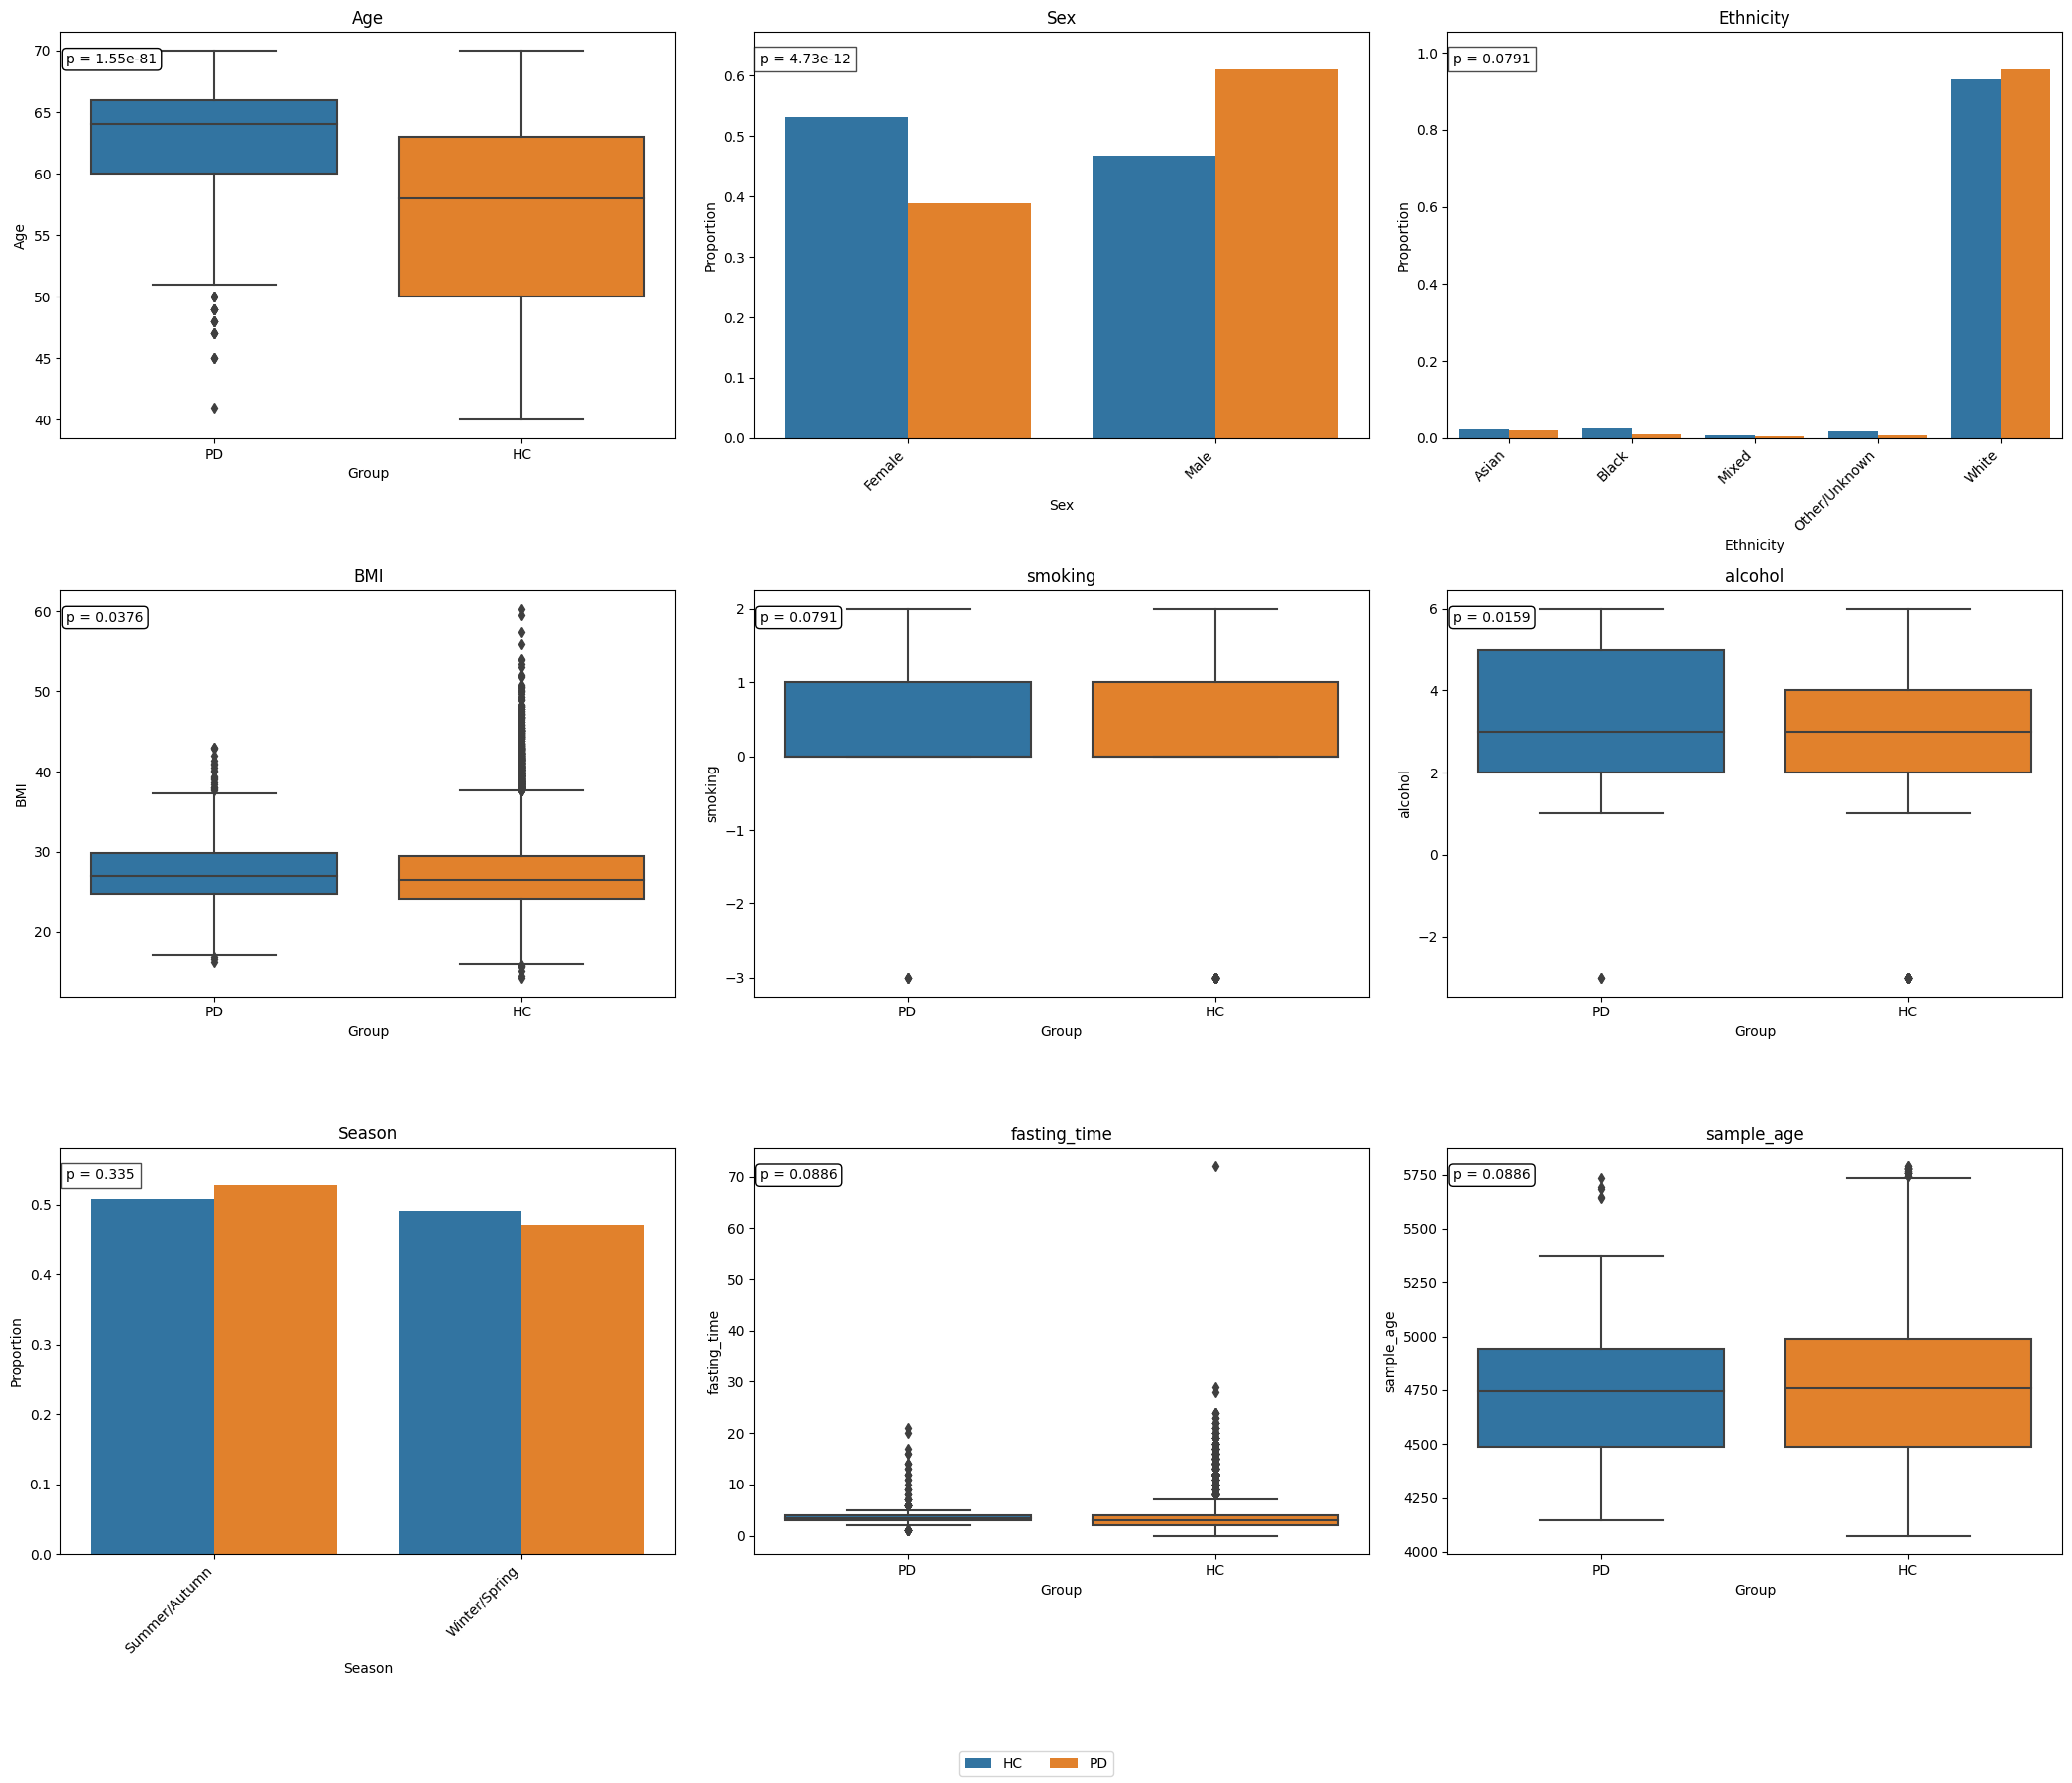

In [92]:
covariates_cols = ["Age", "Sex", "Ethnicity", "BMI", "smoking", 
                   "alcohol", "Season", "fasting_time", "sample_age"]

plot_covariates_with_pvalues(df_pd, "PD", df_hc, "HC", covariates_cols, results_df=results_pd_hc)


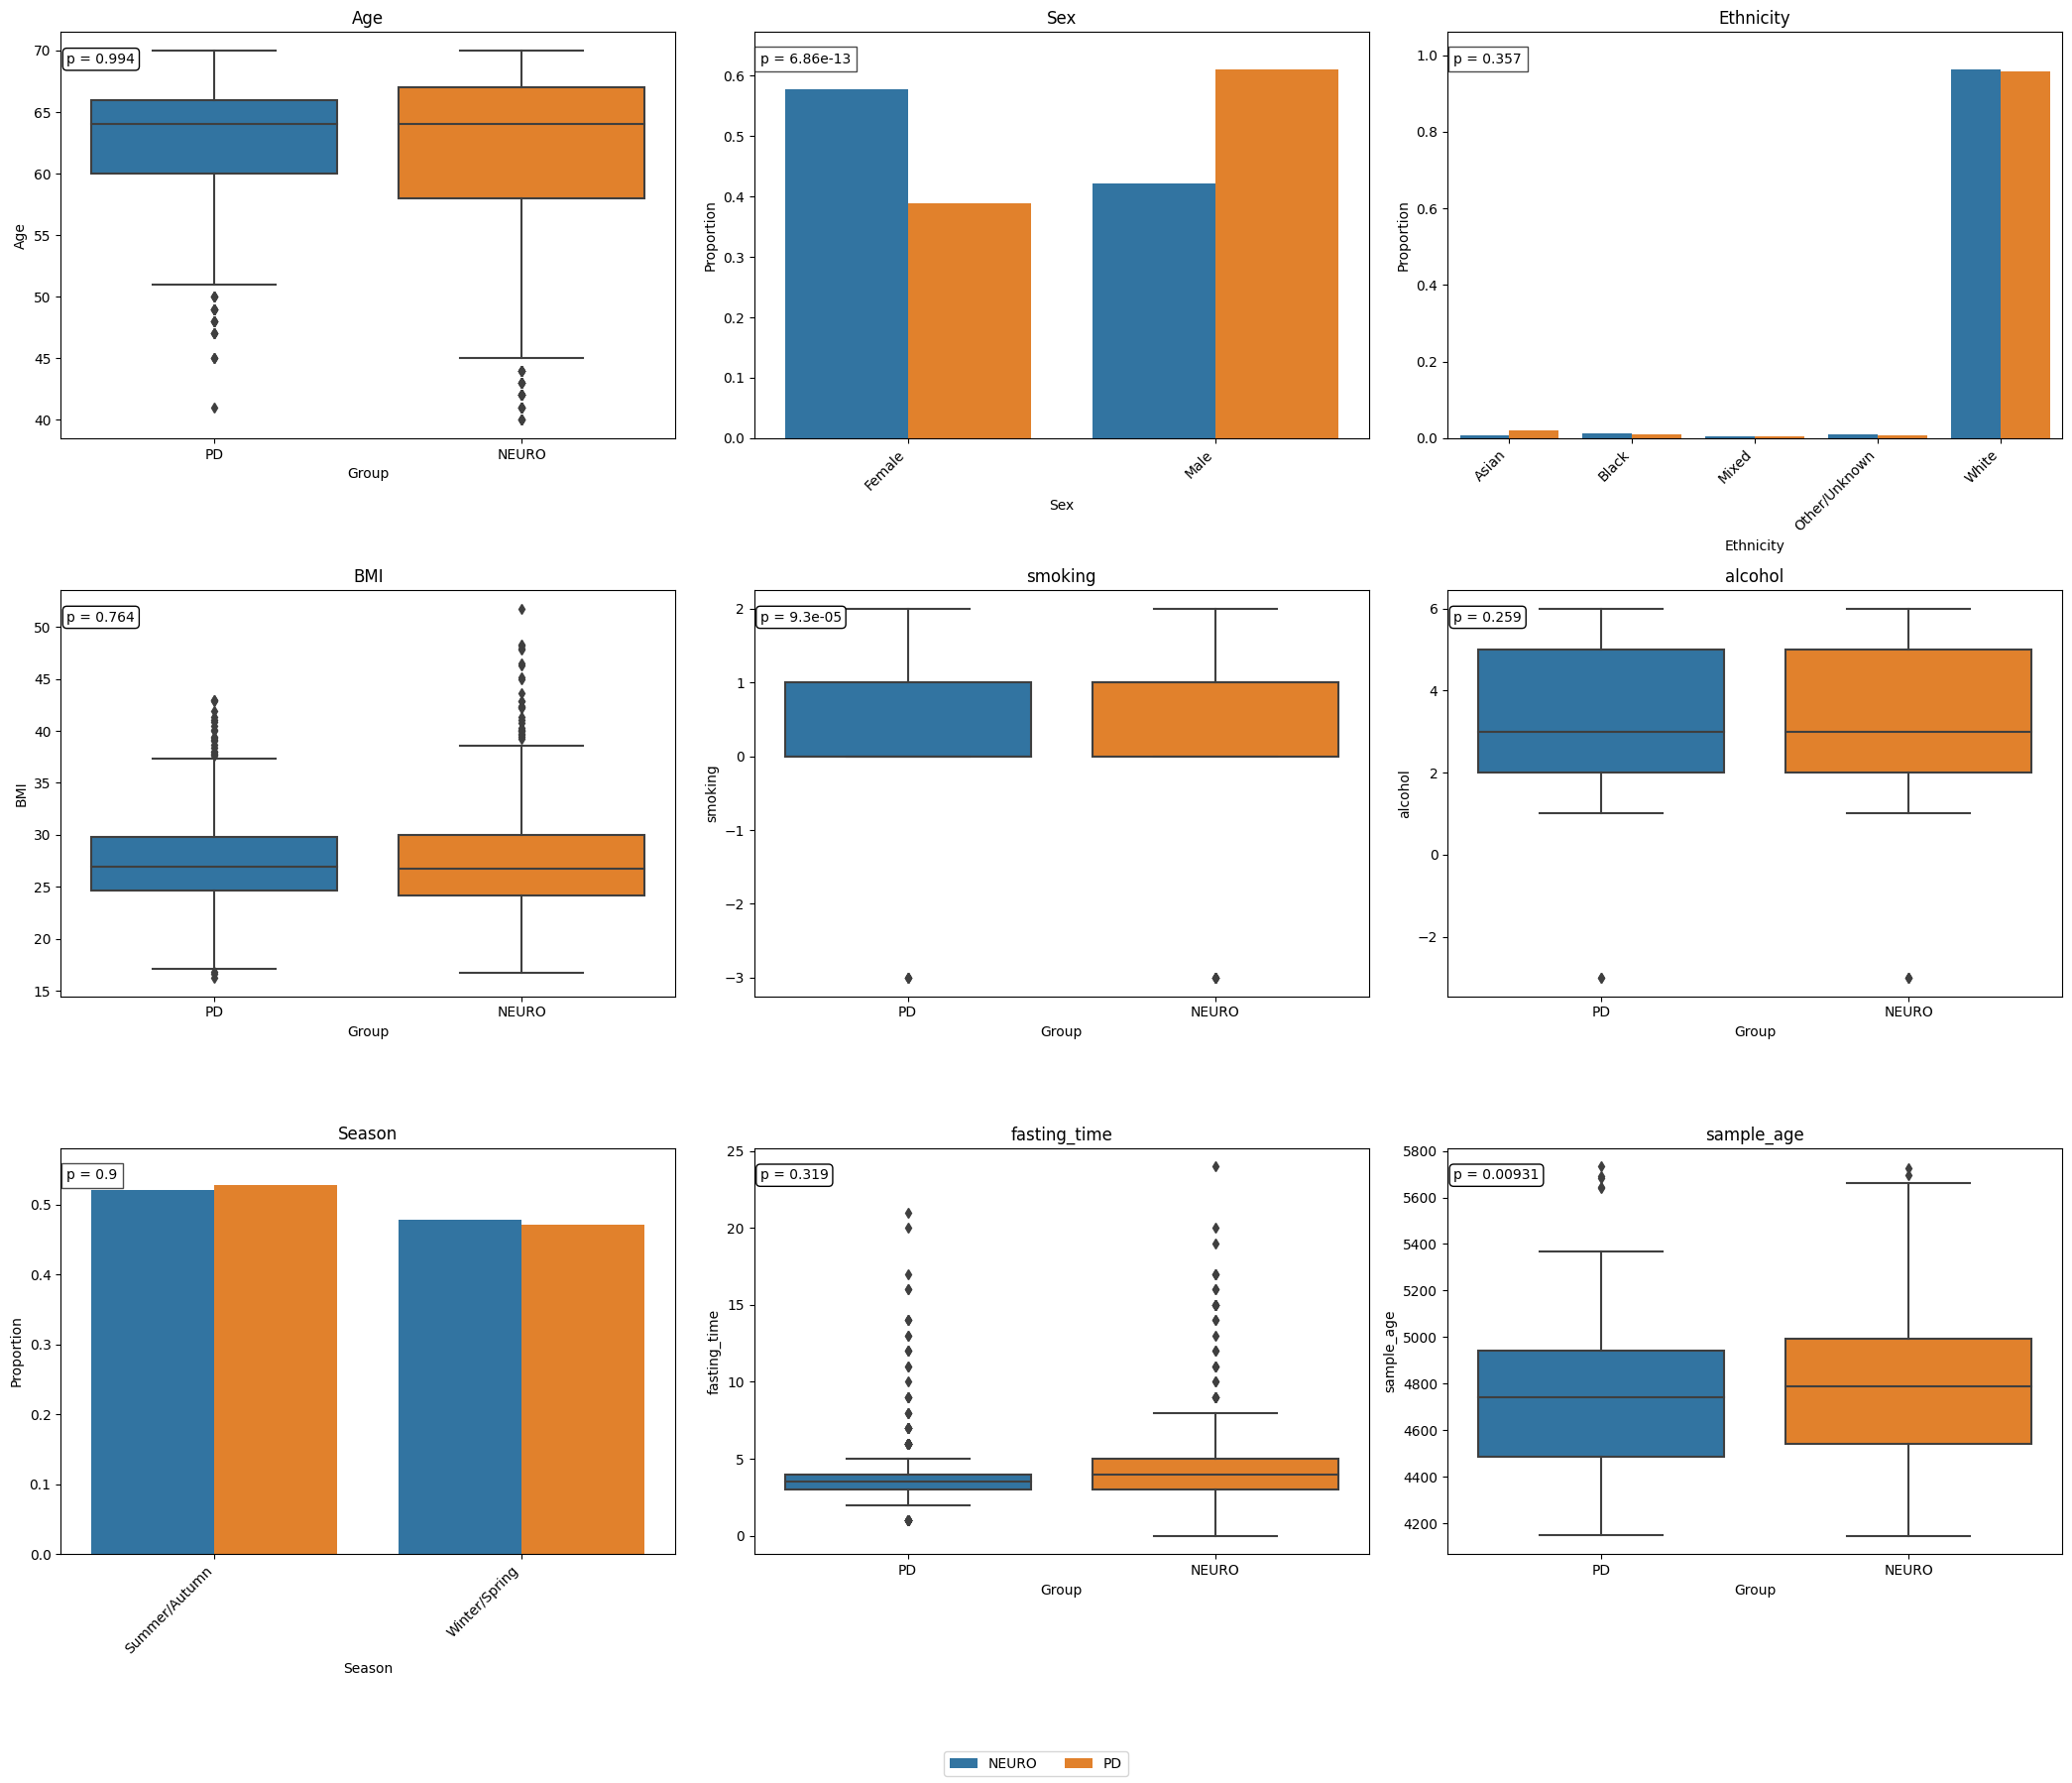

In [93]:
plot_covariates_with_pvalues(df_pd, "PD", df_neuro, "NEURO", covariates_cols, results_df=results_pd_neuro)


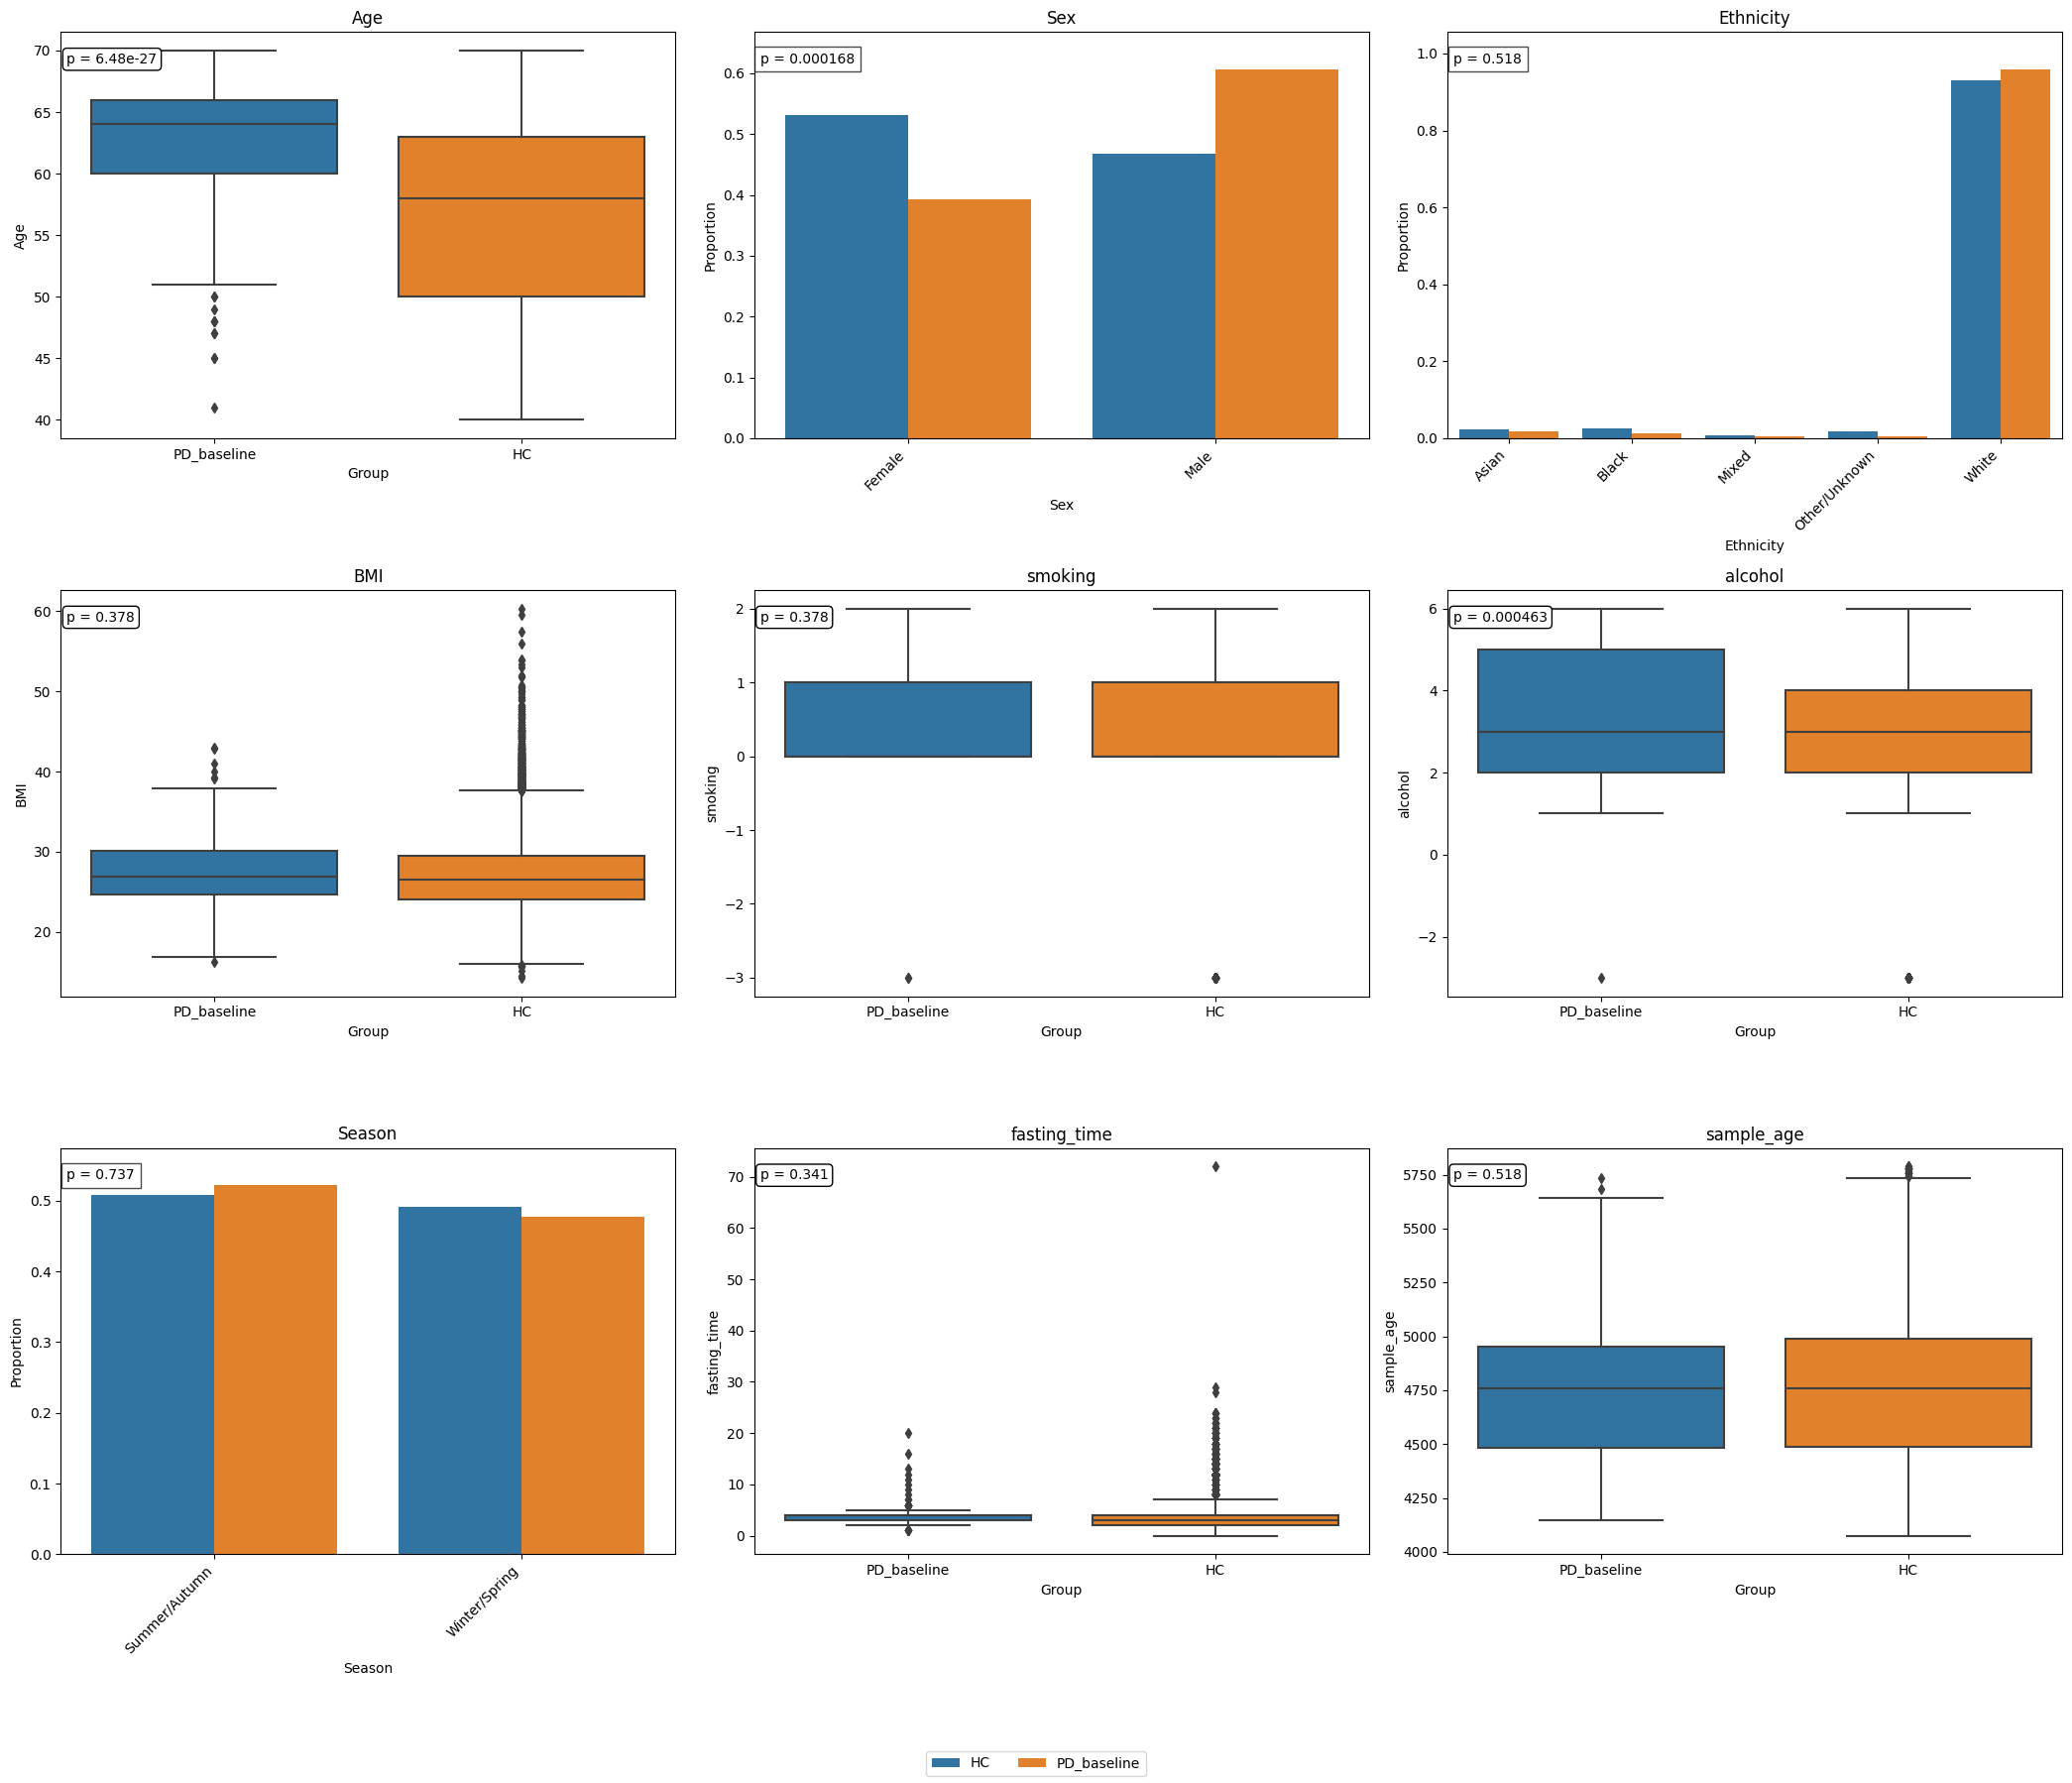

In [94]:
plot_covariates_with_pvalues(pd_baseline, "PD_baseline", df_hc, "HC", covariates_cols, results_df=results_baselinePD_hc)


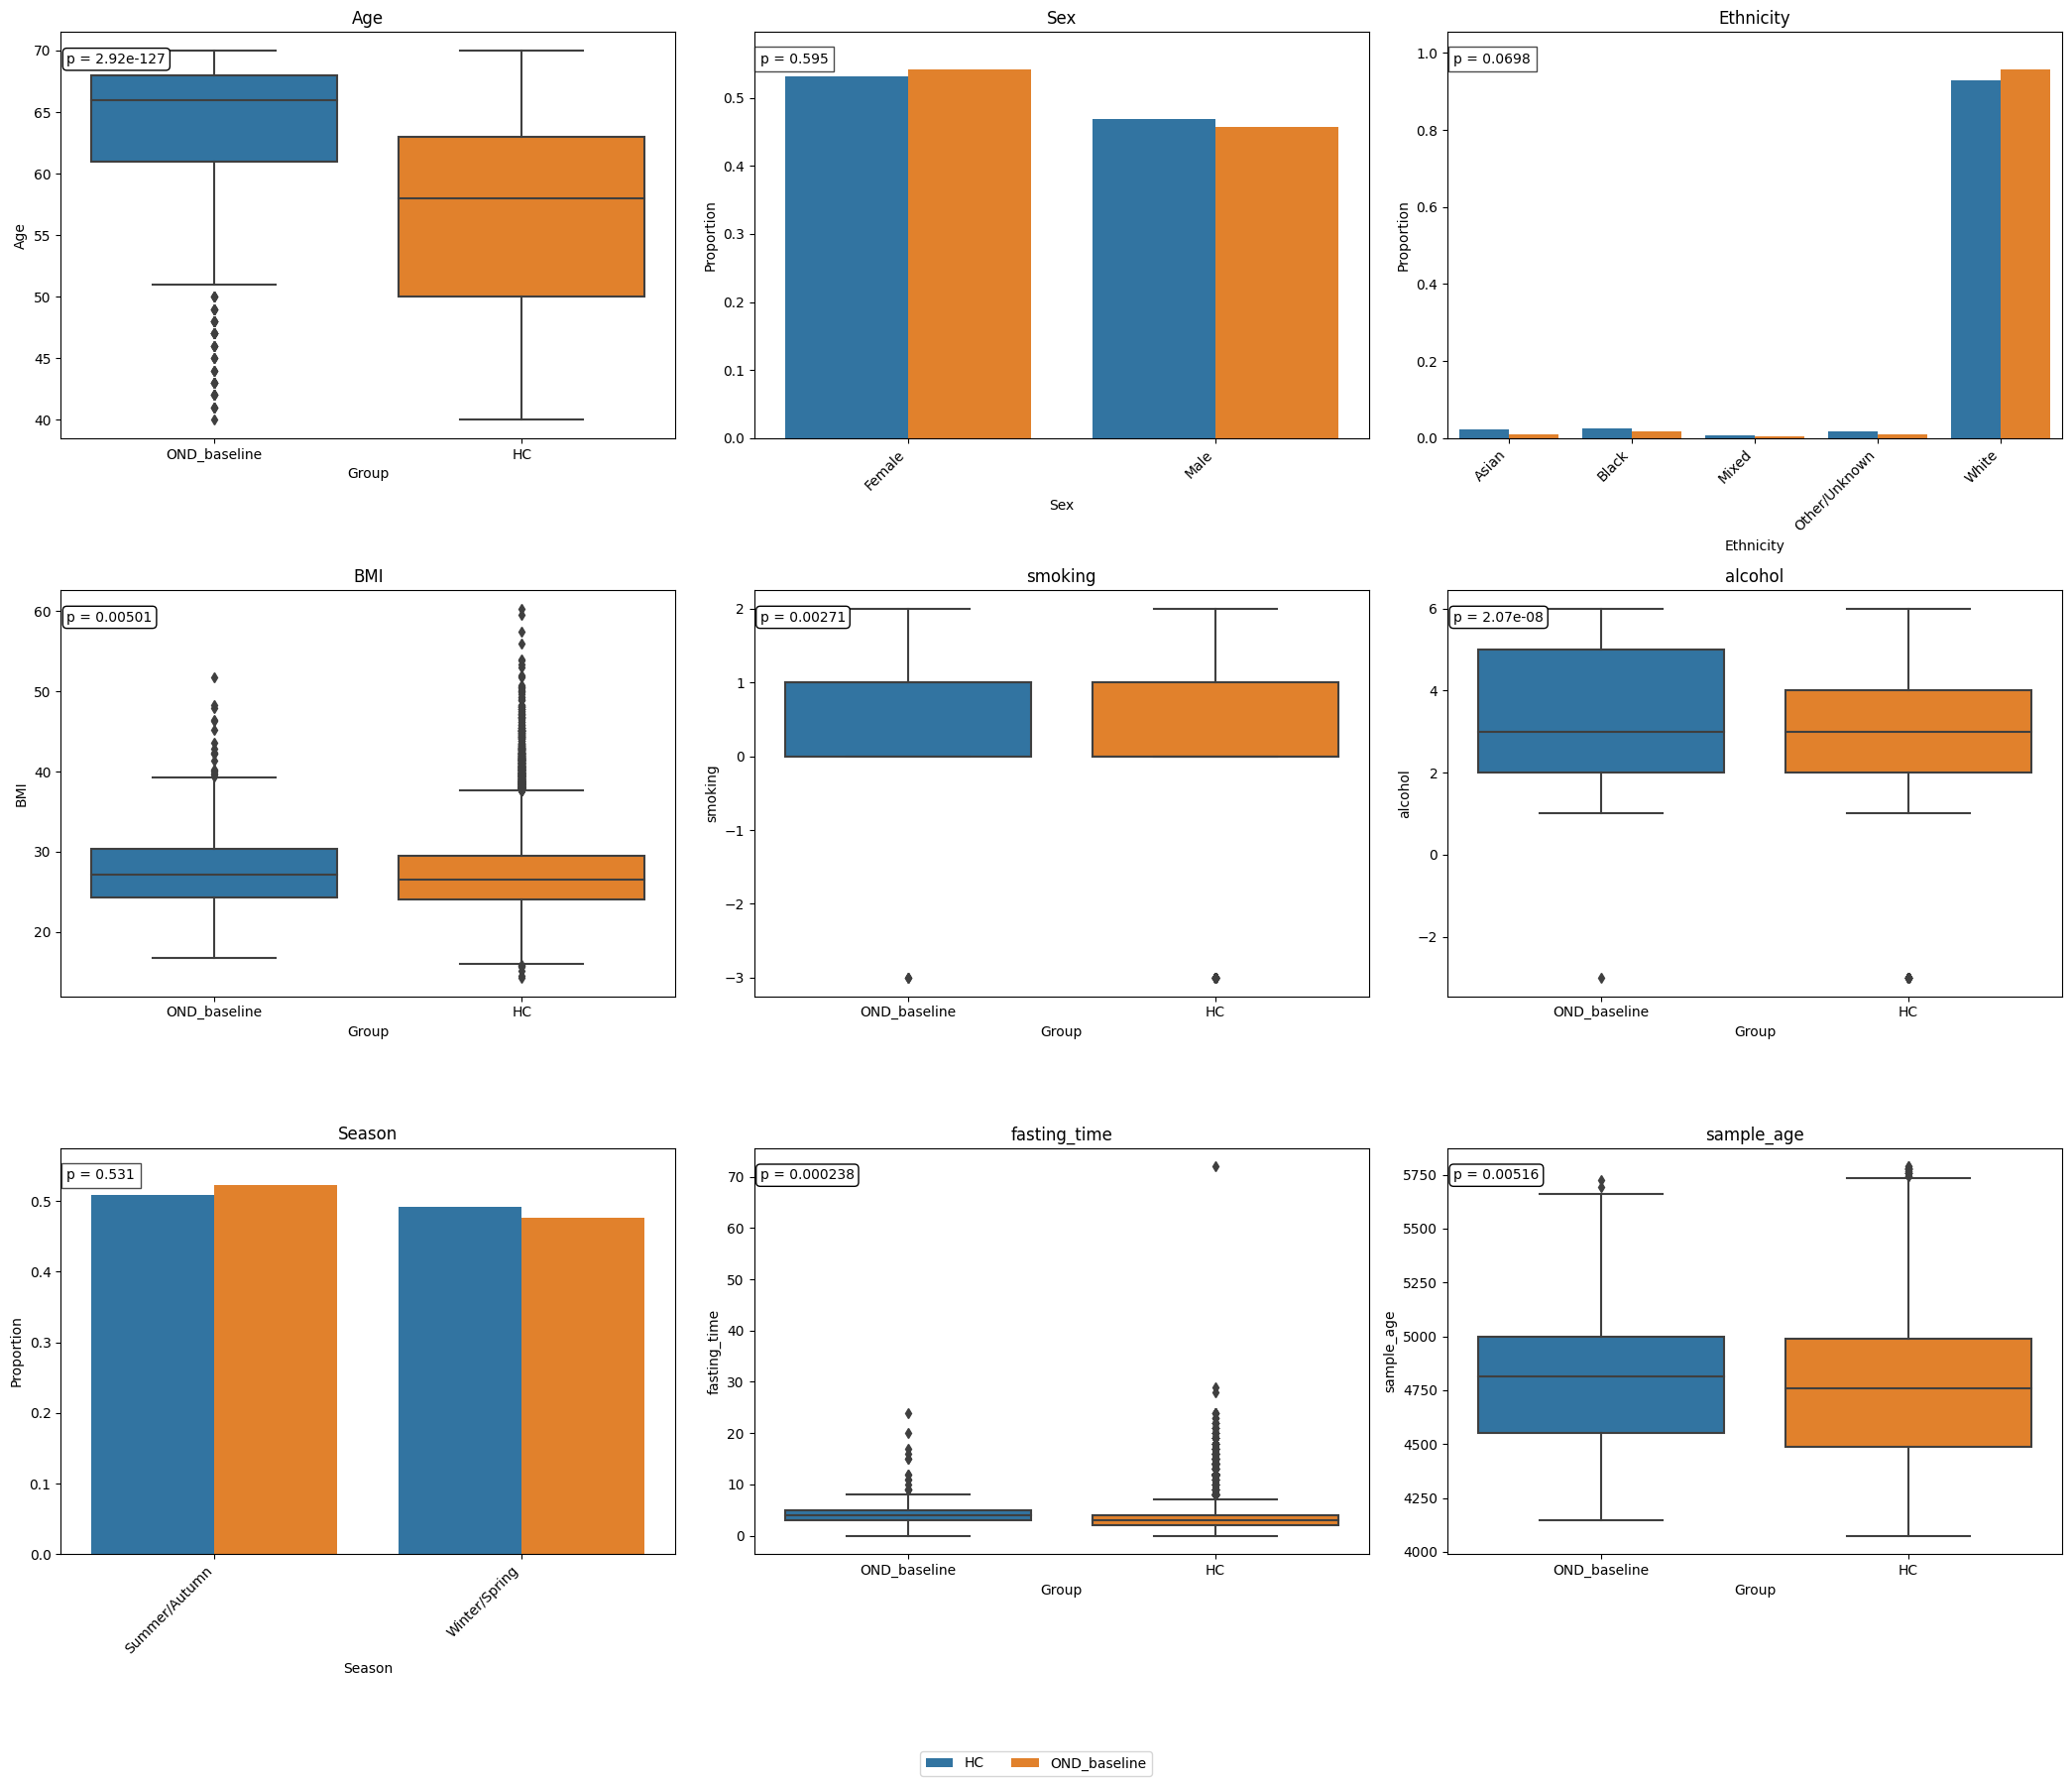

In [95]:
plot_covariates_with_pvalues(ond_prodromals, "OND_baseline", df_hc, "HC", covariates_cols, results_df=results_prodromalsond_hc)


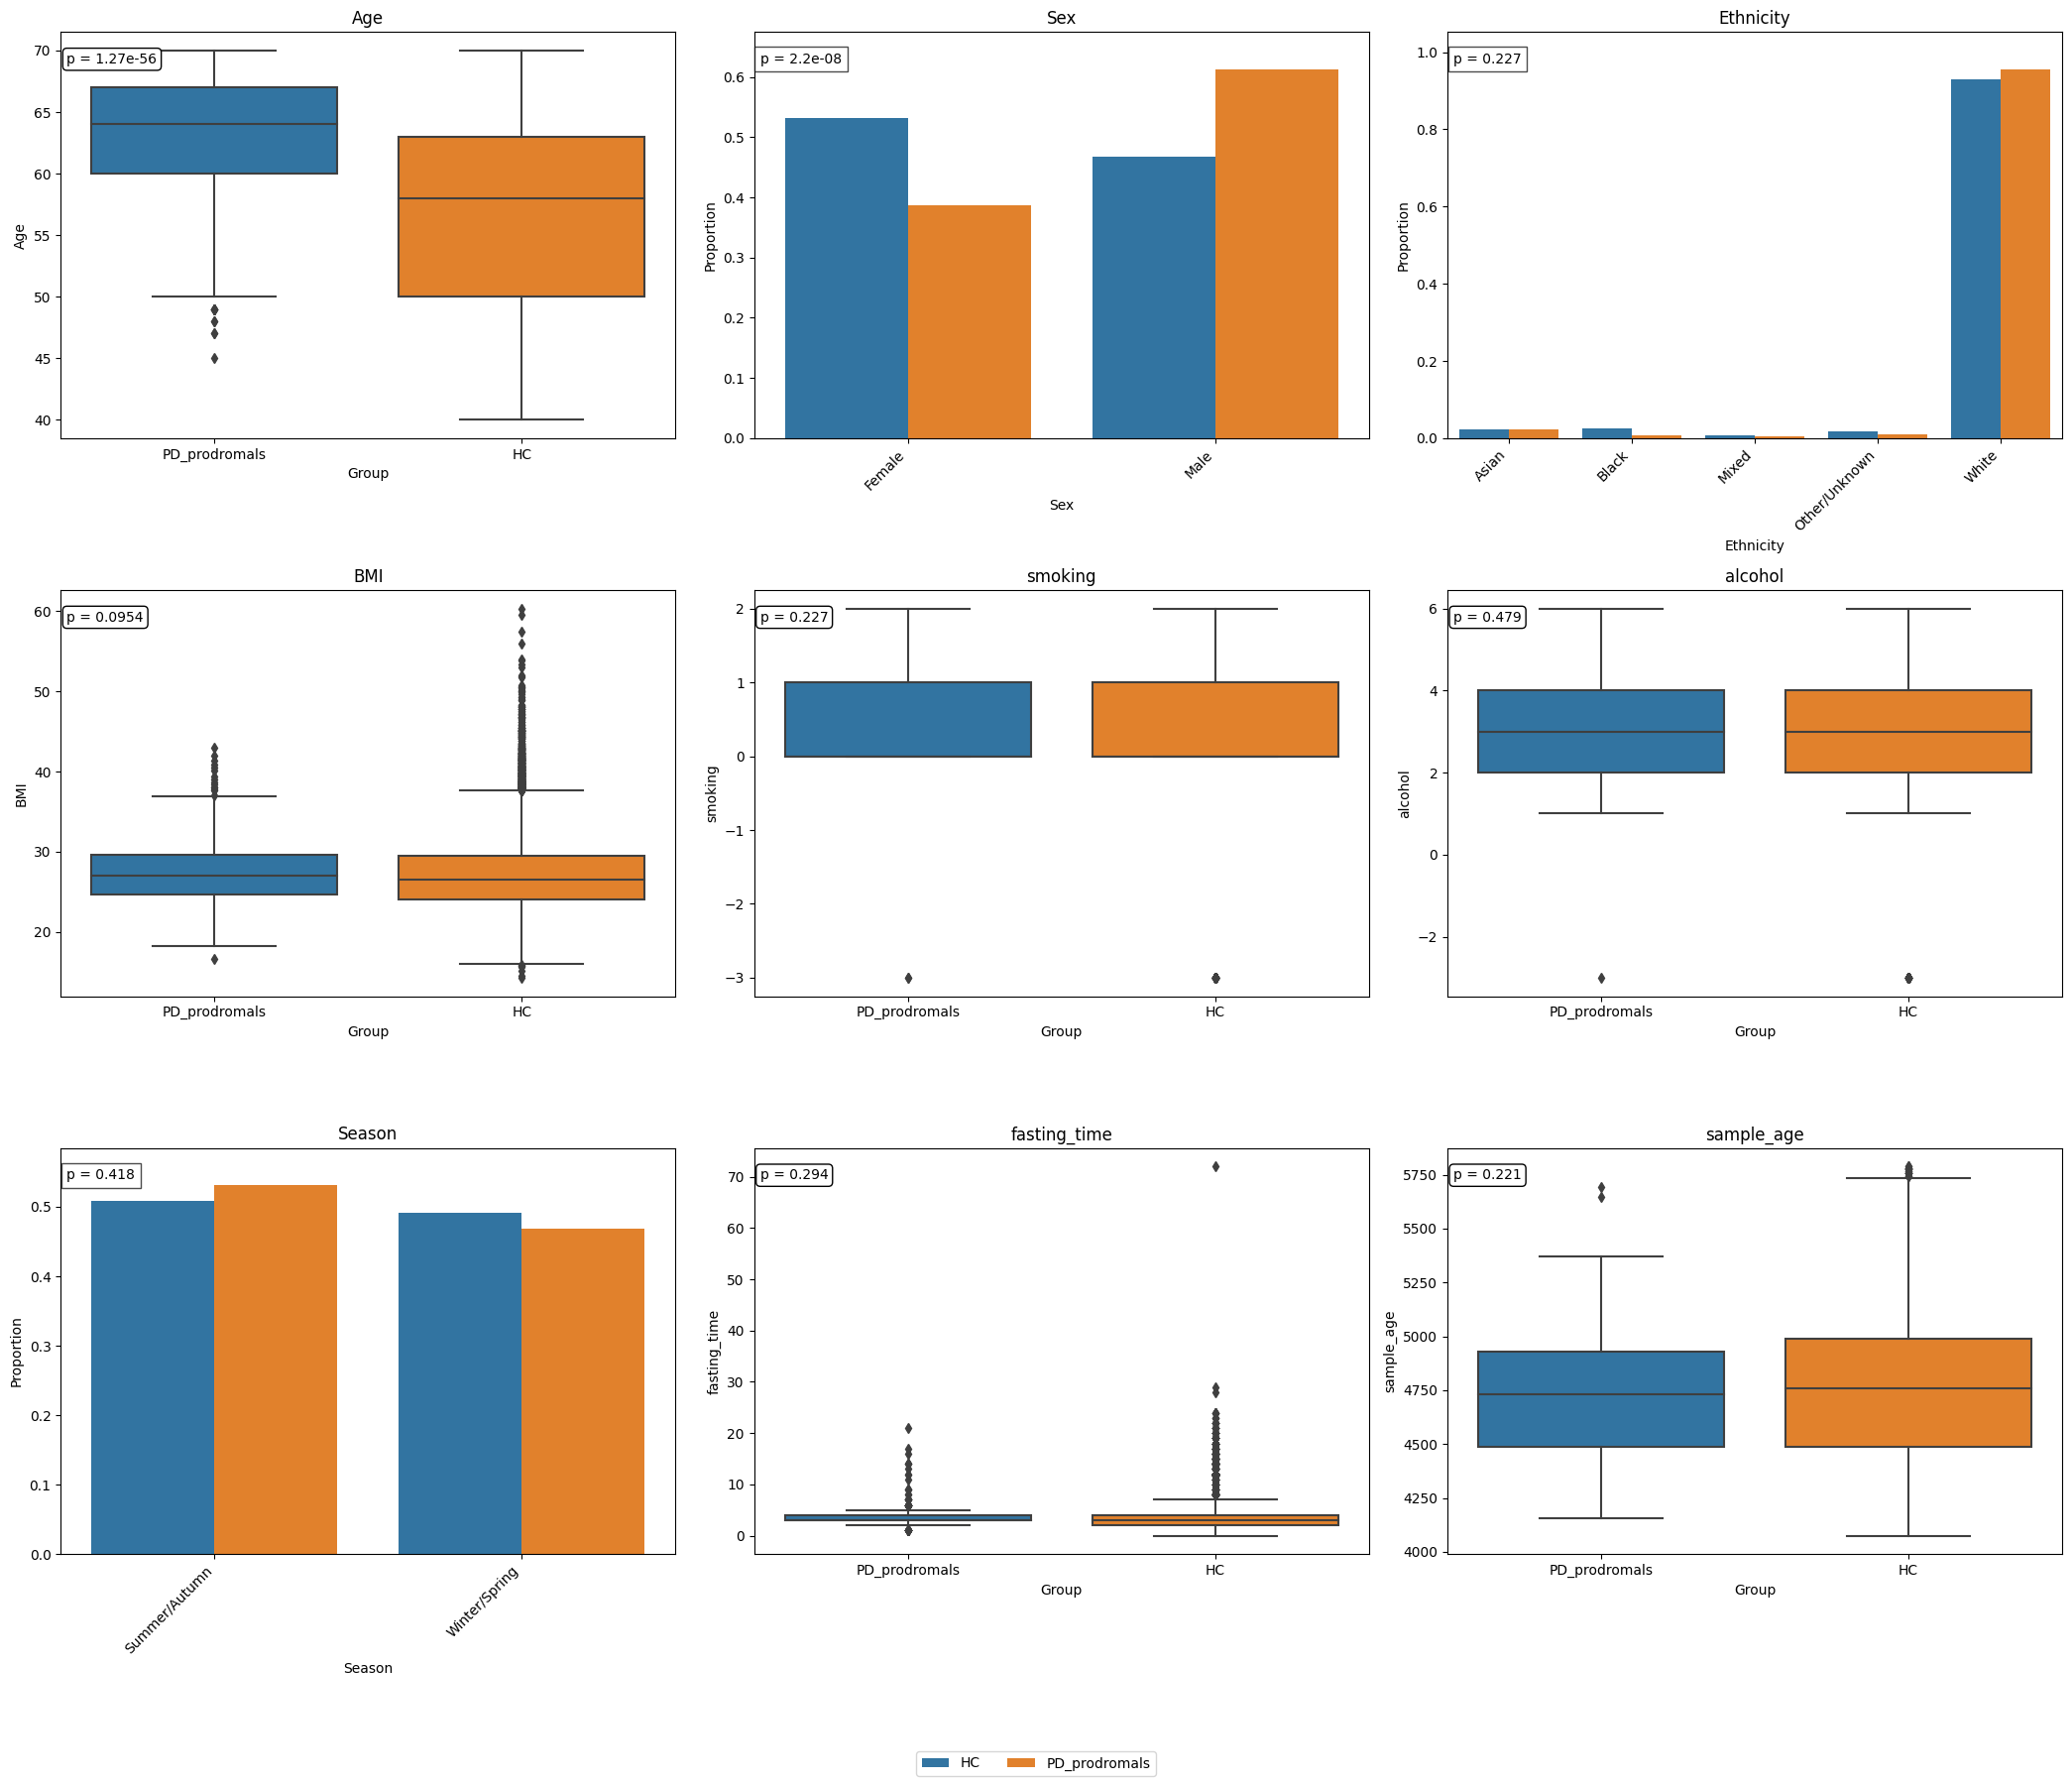

In [96]:
plot_covariates_with_pvalues(pd_prodromals, "PD_prodromals", df_hc, "HC", covariates_cols, results_df=results_prodromalspd_hc)


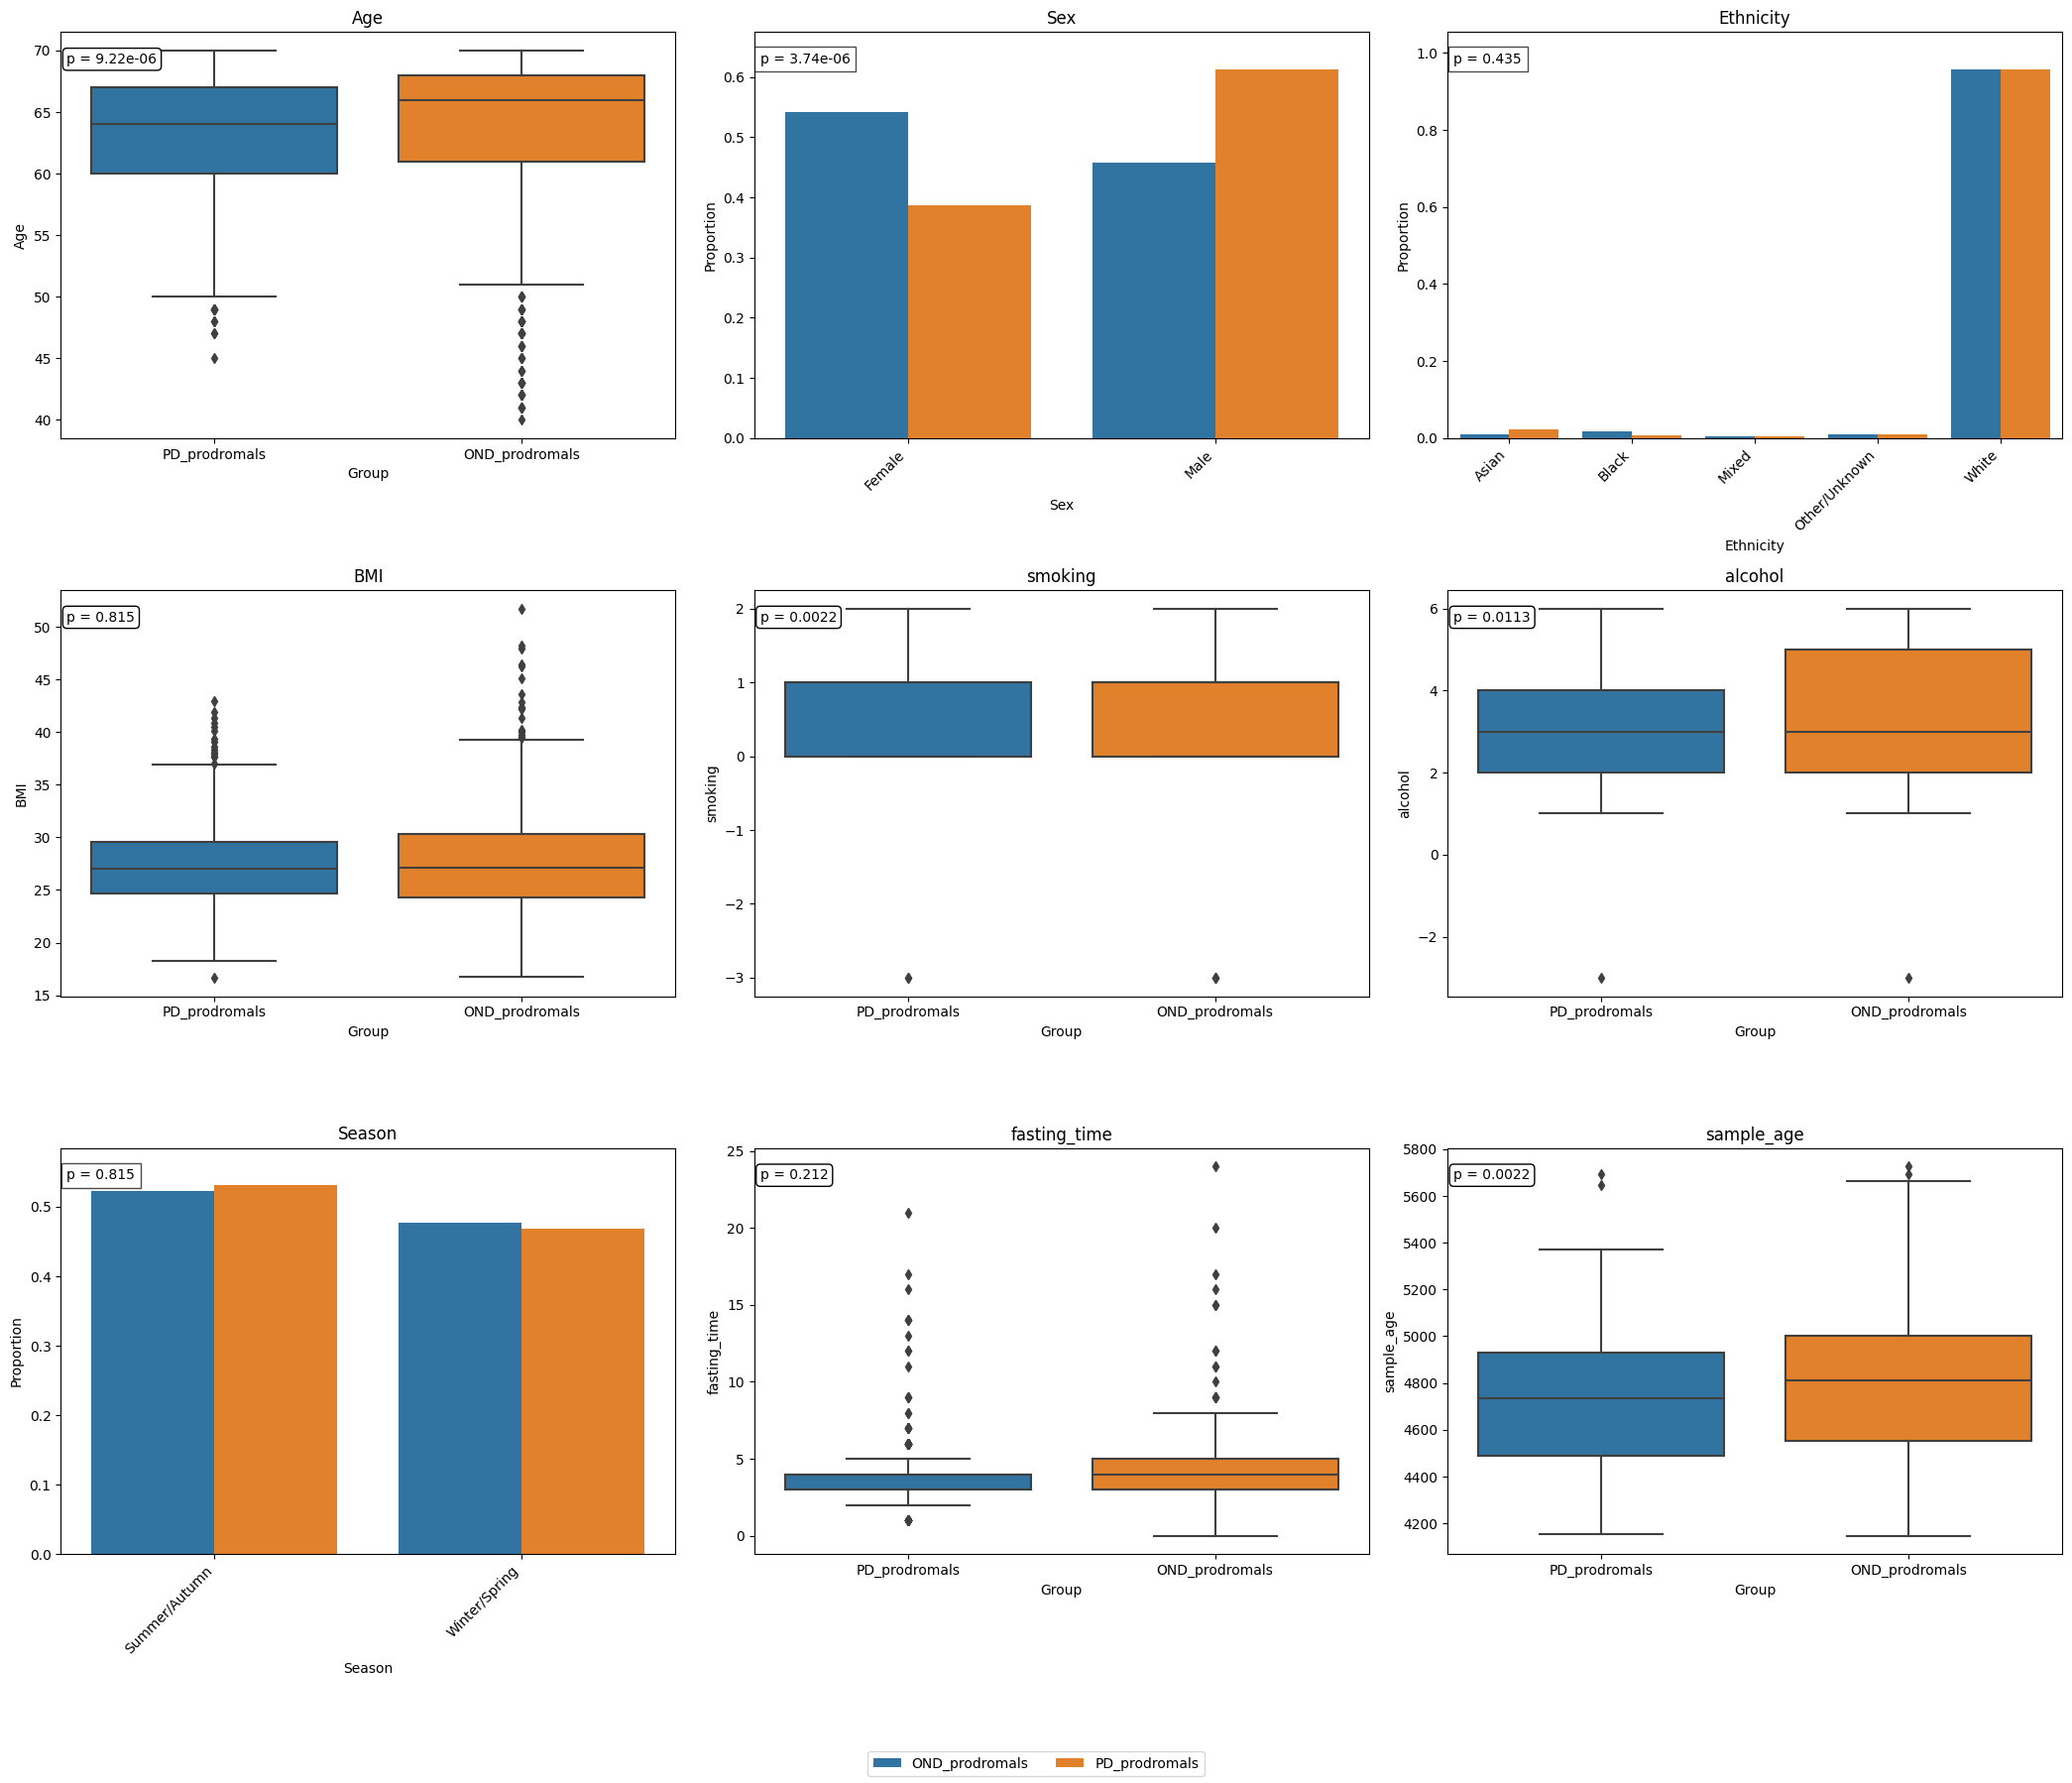

In [97]:
plot_covariates_with_pvalues(pd_prodromals, "PD_prodromals", ond_prodromals, "OND_prodromals", covariates_cols, results_df=results_prodromalspd_prodromalsond)
